# Mask-RCNN Label Generation

In [1]:
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
from pydrake.all import RigidTransform, StartMeshcat

from manipulation.mustard_depth_camera_example import MustardExampleSystem

In [2]:
# Start the visualizer.
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at https://dbd3efd9-6570-475d-9e28-dfec82f78a4a.deepnoteproject.com/7000/


In [3]:
class SimpleCameraSystem:
    def __init__(self):
        diagram = MustardExampleSystem()
        context = diagram.CreateDefaultContext()

        # setup
        meshcat.SetProperty("/Background", "visible", False)

        # getting data
        self.point_cloud = diagram.GetOutputPort("camera0_point_cloud").Eval(context)
        self.depth_im_read = (
            diagram.GetOutputPort("camera0_depth_image").Eval(context).data.squeeze()
        )
        self.depth_im = deepcopy(self.depth_im_read)
        self.depth_im[self.depth_im == np.inf] = 10.0
        label_im = (
            diagram.GetOutputPort("camera0_label_image").Eval(context).data.squeeze()
        )
        self.rgb_im = diagram.GetOutputPort("camera0_rgb_image").Eval(context).data
        self.mask = label_im == 1

        # draw visualization
        meshcat.SetObject("point_cloud", self.point_cloud)

        # camera specs
        cam0 = diagram.GetSubsystemByName("camera0")
        cam0_context = cam0.GetMyMutableContextFromRoot(context)
        self.X_WC = cam0.GetOutputPort("body_pose_in_world").Eval(cam0_context)
        self.X_WC = RigidTransform(self.X_WC)  # See drake issue #15973
        self.cam_info = cam0.default_depth_render_camera().core().intrinsics()

        # get points for mustard bottle
        depth_mustard = self.mask * self.depth_im
        u_range = np.arange(depth_mustard.shape[0])
        v_range = np.arange(depth_mustard.shape[1])
        depth_v, depth_u = np.meshgrid(v_range, u_range)
        depth_pnts = np.dstack([depth_u, depth_v, depth_mustard])
        depth_pnts = depth_pnts.reshape([depth_pnts.shape[0] * depth_pnts.shape[1], 3])
        pC = self.project_depth_to_pC(depth_pnts)
        p_C_mustard = pC[pC[:, 2] > 0]
        self.p_W_mustard = self.X_WC.multiply(p_C_mustard.T).T

    def get_color_image(self):
        return deepcopy(self.rgb_im[:, :, 0:3])

    def get_intrinsics(self):
        # read camera intrinsics
        cx = self.cam_info.center_x()
        cy = self.cam_info.center_y()
        fx = self.cam_info.focal_x()
        fy = self.cam_info.focal_y()
        return cx, cy, fx, fy

    def project_depth_to_pC(self, depth_pixel):
        """
        project depth pixels to points in camera frame
        using pinhole camera model
        Input:
            depth_pixels: numpy array of (nx3) or (3,)
        Output:
            pC: 3D point in camera frame, numpy array of (nx3)
        """
        # switch u,v due to python convention
        v = depth_pixel[:, 0]
        u = depth_pixel[:, 1]
        Z = depth_pixel[:, 2]
        cx, cy, fx, fy = self.get_intrinsics()
        X = (u - cx) * Z / fx
        Y = (v - cy) * Z / fy
        pC = np.c_[X, Y, Z]
        return pC


def bbox(img):
    a = np.where(img != 0)
    bbox = ([np.min(a[0]), np.max(a[0])], [np.min(a[1]), np.max(a[1])])
    return bbox


env = SimpleCameraSystem()
X_WC = env.X_WC
p_W_mustard = env.p_W_mustard
K = env.cam_info.intrinsic_matrix()
rgb_im = env.get_color_image()

# Generate Mask Labels

In the lecture, you have learned about Mask-RCNN. A major difficulty in training/fine-tuning Mask-RCNN is to obtain high-quality real training data, especially the mask labels for the objects of interest. Although you can get training labels from [Amazon Mechanical Turk](https://www.mturk.com/), it is a paid service and you will have to wait for some time until you get your data labeled. An alternative method is to design clever pipelines to generate labeled masks automatically without requiring manual labor.  

Consider a setup where an object of interest is placed on a planar surface, and an RGBD camera is mounted at a fixed location pointing to the object. From the RGBD camera, you should be able to generate the corresponding point clouds of the desired object and the surrounding environment (e.g. planar surface). You can easily remove the points associated with the planar surface (recall RANSAC exercise in the problem set 2). The remaining points then should all belong to the desired object. To generate mask labels, all you need to do is to project the points back to the camera image plane using the pinhole camera model!

Let's quickly review the pinhole camera model!

In problem set 5, you played with [pinhole camera model](https://docs.opencv.org/3.4/d9/d0c/group__calib3d.html). In particular, you used the pinhole camera model to map the depth pixels to 3D points. See the `SimpleCameraSystem` class above to review how this works.

The mathematical description of the pinhole camera model is written below (you may also use the intrinsics matrix by `env.cam_info.intrinsic_matrix()`).

The camera intrinsics are:
$$X_c = (u-c_x)\frac{Z_c}{f_x}$$

$$Y_c = (v-c_y)\frac{Z_c}{f_y}$$

Notations:
- $f_x$: focal length in x direction
- $f_y$: focal length in y direction
- $c_x$: principal point in x direction (pixels)
- $c_y$: principal point in y direction (pixels)
- $(X_C, Y_C, Z_C)$: points in camera frame

where $f_x$, $f_y$, $c_x$, $c_y$ specify the intrinsics of the camera.

The diagram of the pinhole camera model below is found from [OpenCV documentation](https://docs.opencv.org/3.4/d9/d0c/group__calib3d.html). Note that the $u$ and $v$ directions are reversed in Python due to the difference in the convention.

![](https://docs.opencv.org/3.4/pinhole_camera_model.png)

## Generate Mask from Point Clouds

**9.1a** Now given the points of the mustard bottle in the world frame p_W_mustard, can you re-project these points back to the image plane to construct the mask of the mustard bottle? Note that you may need to reverse u,v indices to get the mask of the mustard bottle upright. Your mask should be of the same size as the original depth image, which is (480, 640)

In [4]:
def deproject_pW_to_image(p_W_mustard, cx, cy, fx, fy, X_WC):
    """
    convert points in the world frame to camera pixels
    Input:
        - p_W_mustard: points of the mustard bottle in world frame (nx3)
        - fx, fy, cx, cy: camera intrinsics
        - X_WC: camera pose in the world frame
    Output:
        - mask: numpy array of size 480x640
    """

    mask = np.zeros([480, 640])

    X_CW = X_WC.inverse()
    p_C_mustard = X_CW.multiply(p_W_mustard.T).T

    # Project 3D points in camera frame to 2D image coordinates
    u = ((p_C_mustard[:, 0] * fx) / p_C_mustard[:, 2]) + cx
    v = ((p_C_mustard[:, 1] * fy) / p_C_mustard[:, 2]) + cy

    valid_indices = np.where(
        (u >= 0) & (u < mask.shape[1]) & (v >= 0) & (v < mask.shape[0]) & (p_C_mustard[:, 2] > 0)
    )[0]

    u_valid = np.round(u[valid_indices]).astype(int)
    v_valid = np.round(v[valid_indices]).astype(int)
    mask[v_valid, u_valid] = True

    return mask

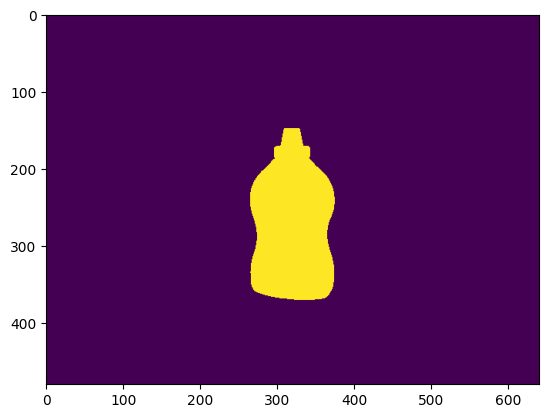

In [5]:
cx, cy, fx, fy = env.get_intrinsics()
mask = deproject_pW_to_image(p_W_mustard, cx, cy, fx, fy, X_WC)
plt.imshow(mask)

You should be able to visually verify that the generated mask perfectly align with the mustard bottle!

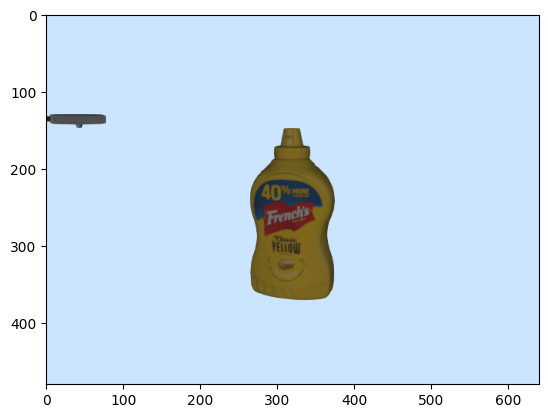

In [6]:
plt.imshow(rgb_im)

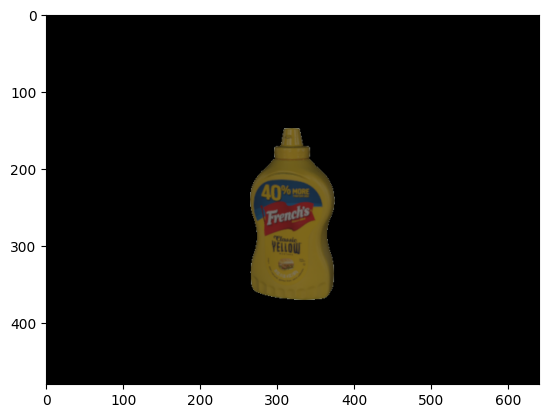

In [7]:
masked_rgb = rgb_im * mask[:, :, np.newaxis].astype(int)
plt.imshow(masked_rgb)

# Analysis for Cluttered Scenes
**Assume we have a scene with more than one object, i.e., we now have a Cheez-It box in the scene along with the mustard bottle. Let’s explore how our pipeline can work for generating object masks in these scenarios (suppose we can still easily crop the objects in the scene to a region about a flat empty surface). Answer the following questions.**

**9.1.b** A direct and unmodified application of our pipeline above would use the full raw point cloud which includes both objects. Using this unmodified method, can you get the separate masks of the mustard bottle and Cheez-It box? Explain your reasoning.

Now, Suppose we add an extra processing step in our pipeline, where we perform clustering on the point cloud and obtain labels for which points belong to each cluster (i.e., suppose we attempt to cluster it into two clusters using an algorithm like [DBSCAN](http://www.open3d.org/docs/latest/tutorial/Basic/pointcloud.html#DBSCAN-clustering))

**9.1.c** Assume the Cheez-It box is relatively far away from the mustard bottle, i.e., they are not touching and there at least a few cm of free space in between them. With the objects separated, will our pipeline with clustering added be able to reliably provide separate masks of the mustard bottle and the Cheez-It box? Explain your reasoning.

**9.1.d** Assume the Cheez-It box and mustard bottle are extremely close to each other, i.e., the mustard bottle might be resting on top of the flat Cheez-It box. With the objects touching each other, will our pipeline with clustering added be able to reliably provide separate masks of the mustard bottle and the Cheez-It box? Explain your reasoning.

# Generate Training Images and Masks via Data Augmentation

A major benefit to leveraging models such as Mask-RCNN is that they have greater capability for handling complex scenes. As discussed before, a downside is that models tend to require large amounts of high quality training data in order to reach this level of robustness.

[Data augmentation](https://en.wikipedia.org/wiki/Data_augmentation) is commonly used to generate more training data from the existing data. For example, a common trick to generate training images and masks for occluded scenes is to randomly insert rendered objects on top of the real image. Similarly, you can randomly scale, flip, rotate, duplicate, and crop to "simulate" more complex scenes.

<figure>
<center>
<img src='https://developers.google.com/machine-learning/practica/image-classification/images/data_augmentation.png' />
<figcaption>Example Image Data Augmentation (credit: developers.google.com)</figcaption></center>
</figure>

In this exercise, we ask you to explore different ways to augment from our existing mustard bottle image:
- flipping
- translating
- duplication 
- cropping
- adding noise 

**9.1e** **Please complete the function below to generate 1 more pair of a color image and mask label using at least 2 tricks above to augment your data. You may use Numpy only!** 

**Note: make sure you display both of the your new image and mask below in your notebook submission. Also submit your new image and mask in your written submission. Your results will be visually graded**

In [8]:
def augment_mustard_bottle(rgb_im, mask):
    """
    perform random rotation, scaling, and duplication to generate
    more training images and labels
    rgb_im: original rgb image of the mustard bottle
    mask: binary mask of the mustard bottle
    """
    augmented_rgb = np.zeros((480, 640, 3))
    augmented_mask = np.zeros((480, 640))
    return augmented_rgb, augmented_mask

In [9]:
# Translation with flip over x-axis


def augment_mustard_bottle(rgb_im, mask):
    """
    perform random rotation, scaling, and duplication to generate
    more training images and labels
    rgb_im: original rgb image of the mustard bottle
    mask: binay mask of the mustard bottle
    """
    augmented_rgb = np.zeros((480, 640, 3))
    augmented_mask = np.zeros((480, 640))

    augmented_rgb = np.roll(np.flip(rgb_im, axis=0), 200, axis=1)
    augmented_mask = np.roll(np.flip(mask, axis=0), 200, axis=1)

    return augmented_rgb, augmented_mask

In [10]:
new_img, new_mask = augment_mustard_bottle(rgb_im, mask)

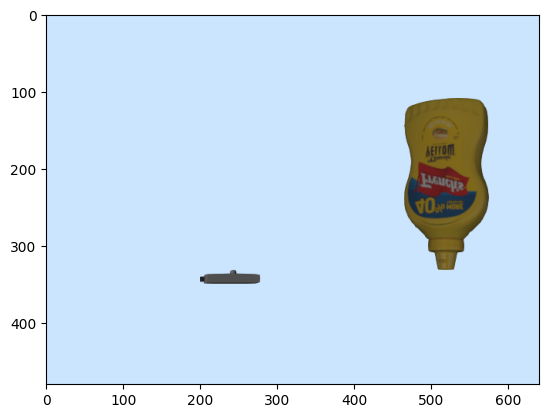

In [11]:
plt.imshow(new_img)

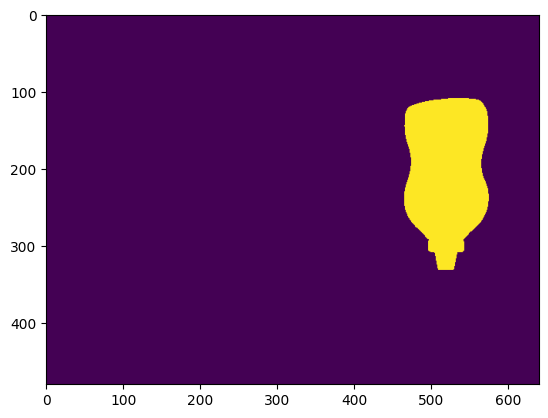

In [12]:
plt.imshow(new_mask)

## How will this notebook be Graded?

If you are enrolled in the class, this notebook will be graded using [Gradescope](www.gradescope.com). You should have gotten the enrollement code on our announcement in Piazza. 

For submission of this assignment, you must do two things. 
- Download and submit the notebook `label_generation.ipynb` to Gradescope's notebook submission section, along with your notebook for the other problems.
- Write down your answers to 9.1.b, 9.1.c, and 9.1.d, and add your images from 9.1.e to a separate pdf file and submit it to Gradescope's written submission section. 

We will evaluate the local functions in the notebook to see if the function behaves as we have expected. For this exercise, the rubric is as follows:
- [3 pts] Correct Implementation of `deproject_pW_to_image` method.
- [3 pts] Analysis for Cluttered Scenes: reasonable answers and explanations. 
- [2 pts] Visually reasonable output from `augment_mustard_bottle`.


In [14]:
from manipulation.exercises.grader import Grader
from manipulation.exercises.segmentation.test_mask import TestMask

Grader.grade_output([TestMask], [locals()], "results.json")
Grader.print_test_results("results.json")

Total score is 3/3.

Score for Testing deproject_pW_to_image is 3/3.


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=dbd3efd9-6570-475d-9e28-dfec82f78a4a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>